This notebook explore the publications citing Galaxy

In [55]:
import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import pprint
import re
import requests
import time

from pyzotero import zotero
from scholarly import ProxyGenerator, scholarly

In [47]:
searched_tags = [
    'bacteri', # bacteria, bacterio
    'prokaryot', # prokaryote, prokaryotic
    'microb', # microbiome, microbiota, microbial, microbiology, microbe
    'pathogen',
    'virus',
    'phage',
    'archae',
    'flora',
    'microecology',
    'microorganism', 'micro-organism',
    'microbiome', 'microbiota',
    'metabarcod', # metabarcode, metabarcoding
        '16s', '16 s',
        '18s',
        'amplicon',
        'metataxonom',
    'metagenom', # metagenome, metagenomic
    'metatranscriptom', # metatranscriptome, metatranscriptomic
    'metaproteom', # metaproteome, metaproteomic
    'multi-locus sequence typing', 'multilocus sequence typing', 'mlst',
    'otu'
]

In [52]:
def create_grouping_keywords():
    return {
        'Targeted organisms': {
            'Bacteria': {
                'keywords': ['bacteri', 'prokaryot'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Virus': {
                'keywords': ['virus', 'phage'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Archaea': {
                'keywords': ['archae'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Eukaryote': {
                'keywords': ['eukaryot'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Microbiome': {
                'keywords': ['microbiome', 'microbiota', 'flora', 'ecology', 'community', 'communities'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Pathogen': {
                'keywords': ['pathogen'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            }
        },
        'Technical target': {
            'Isolate': {
                'keywords': ['isolate'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Community (taxonomy) profiling': {
                'keywords': ['otu', 'asv', 'taxonom', 'community', 'communities', 'ecosystem', 'diversity', 'ecology'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Functional analysis': {
                'keywords': ['function'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Interactome': {
                'keywords': ['interaction'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'AMR': {
                'keywords': ['antimicrobial', 'resistan', 'amr'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'MAGs': {
                'keywords': ['mags', 'metagenome-assembled genome', 'assembly'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Gene identification / Biomarker': {
                'keywords': ['gene identification', 'biomarker'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'SNP': {
                'keywords': ['snp', 'single-nucleotide polymorphism'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            '(M)LST': {
                'keywords': ['mlst', 'locus sequence typing'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Annotation': {
                'keywords': ['annotation'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Variant': {
                'keywords': ['variant'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Comparative analysis': {
                'keywords': ['comparative'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
        },
        'Methods': {
            'Metabarcoding': {
                'keywords': ['metabarcod', '16s', '16 s', '18s', 'amplicon', 'metataxonom'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            '(Meta)genomics': {
                'keywords': ['genom'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Metagenomics': {
                'keywords': ['metagenom'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            '(Meta)transcriptomics': {
                'keywords': ['transcriptom'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Metatranscriptomics': {
                'keywords': ['metatranscriptom'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            '(Meta)proteomics': {
                'keywords': ['proteom', 'mass spectrometry'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Metaproteomics': {
                'keywords': ['metaproteom'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Metabolomics': {
                'keywords': ['metabolom', 'metabolite'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
            'Imaging': {
                'keywords': ['imaging'],
                'location': ['tag', 'title', 'abstract'],
                'counts': 0
            },
        }    
    }

def find_kw(string, kws):
    '''
    Return if a 1 keyword in a list is found in a string

    :param string: string to search
    :param kws: list of keywords to search
    '''
    found = False
    for kw in kws:
        if kw in string:
            found = True
    return found

# Galaxy Publication Library

The Galaxy Project uses the Zotero social bookmarking service to organize publications that reference Galaxy. The Galaxy Group lists published articles, conference proceedings, theses, book chapters and books that use, extend, reference or implement Galaxy. 

In [2]:
ZOTERO_API = os.getenv('ZOTERO_API')

In [3]:
zot = zotero.Zotero('1732893', 'group', ZOTERO_API)

In this Galaxy Publication Library, the number of elements is:

In [4]:
element_nb = zot.count_items()
element_nb

22792

## Extract items based on keywords in tags, titles, and abstracts

The library makes extensive use of tags to categorize publications and enable smarter searching. But only papers added after the library was moved to Zotero in September 2017 have automatically added tags.

We extract items related to microbial data analysis by checking if their title, abstract, or tags contains any of following keywords:

In [20]:
conserved_items = []
conserved_tags = set()
excluded_tags = set()
years = {
    "all": {},
    "microbial": {}
}


for y in range(2005, datetime.date.today().year+2):
    years["all"].setdefault(f"{y}", 0)
    years["microbial"].setdefault(f"{y}", 0)

for item in zot.everything(zot.top()):
    year = 0
    
    # get year
    if "date" in item["data"]:
        match = re.match(r".*(2[0-9]{3})", item["data"]["date"])
        if match is not None:
            year = match.group(1)
            years["all"][year] += 1
    
    to_add = False

    # search in tags
    for tag in item['data']['tags']:
        for st in searched_tags:
            if st in tag['tag'].lower():
                conserved_tags.add(tag['tag'].lower())
                to_add = True
            else:
                excluded_tags.add(tag['tag'].lower())

    # search in title and abstract
    for st in searched_tags:
        if 'title' in item['data'] and st in item['data']['title'].lower():
            to_add = True
        if 'abstractNote' in item['data'] and st in item['data']['abstractNote'].lower():
            to_add = True

    # keep item if found
    if to_add:
        conserved_items.append(item)
        if year != 0:
            years["microbial"][year] += 1

Number and percentage of publications related to microbioal data analysis

In [23]:
conserved_element_nb = len(conserved_items)
print(f'{conserved_element_nb} {100 * conserved_element_nb/element_nb}')

4594 20.156195156195157


## Explore conserved items

### Per year

In [25]:
year_df = pd.DataFrame.from_dict(years)
year_df

,all,microbial
2005,1,0
2006,4,0
2007,12,0
2008,32,1
2009,53,3
2010,107,10
2011,205,24
2012,398,69
2013,506,93
2014,741,148


Text(0, 0.5, 'Publications in Galaxy Publication Library')

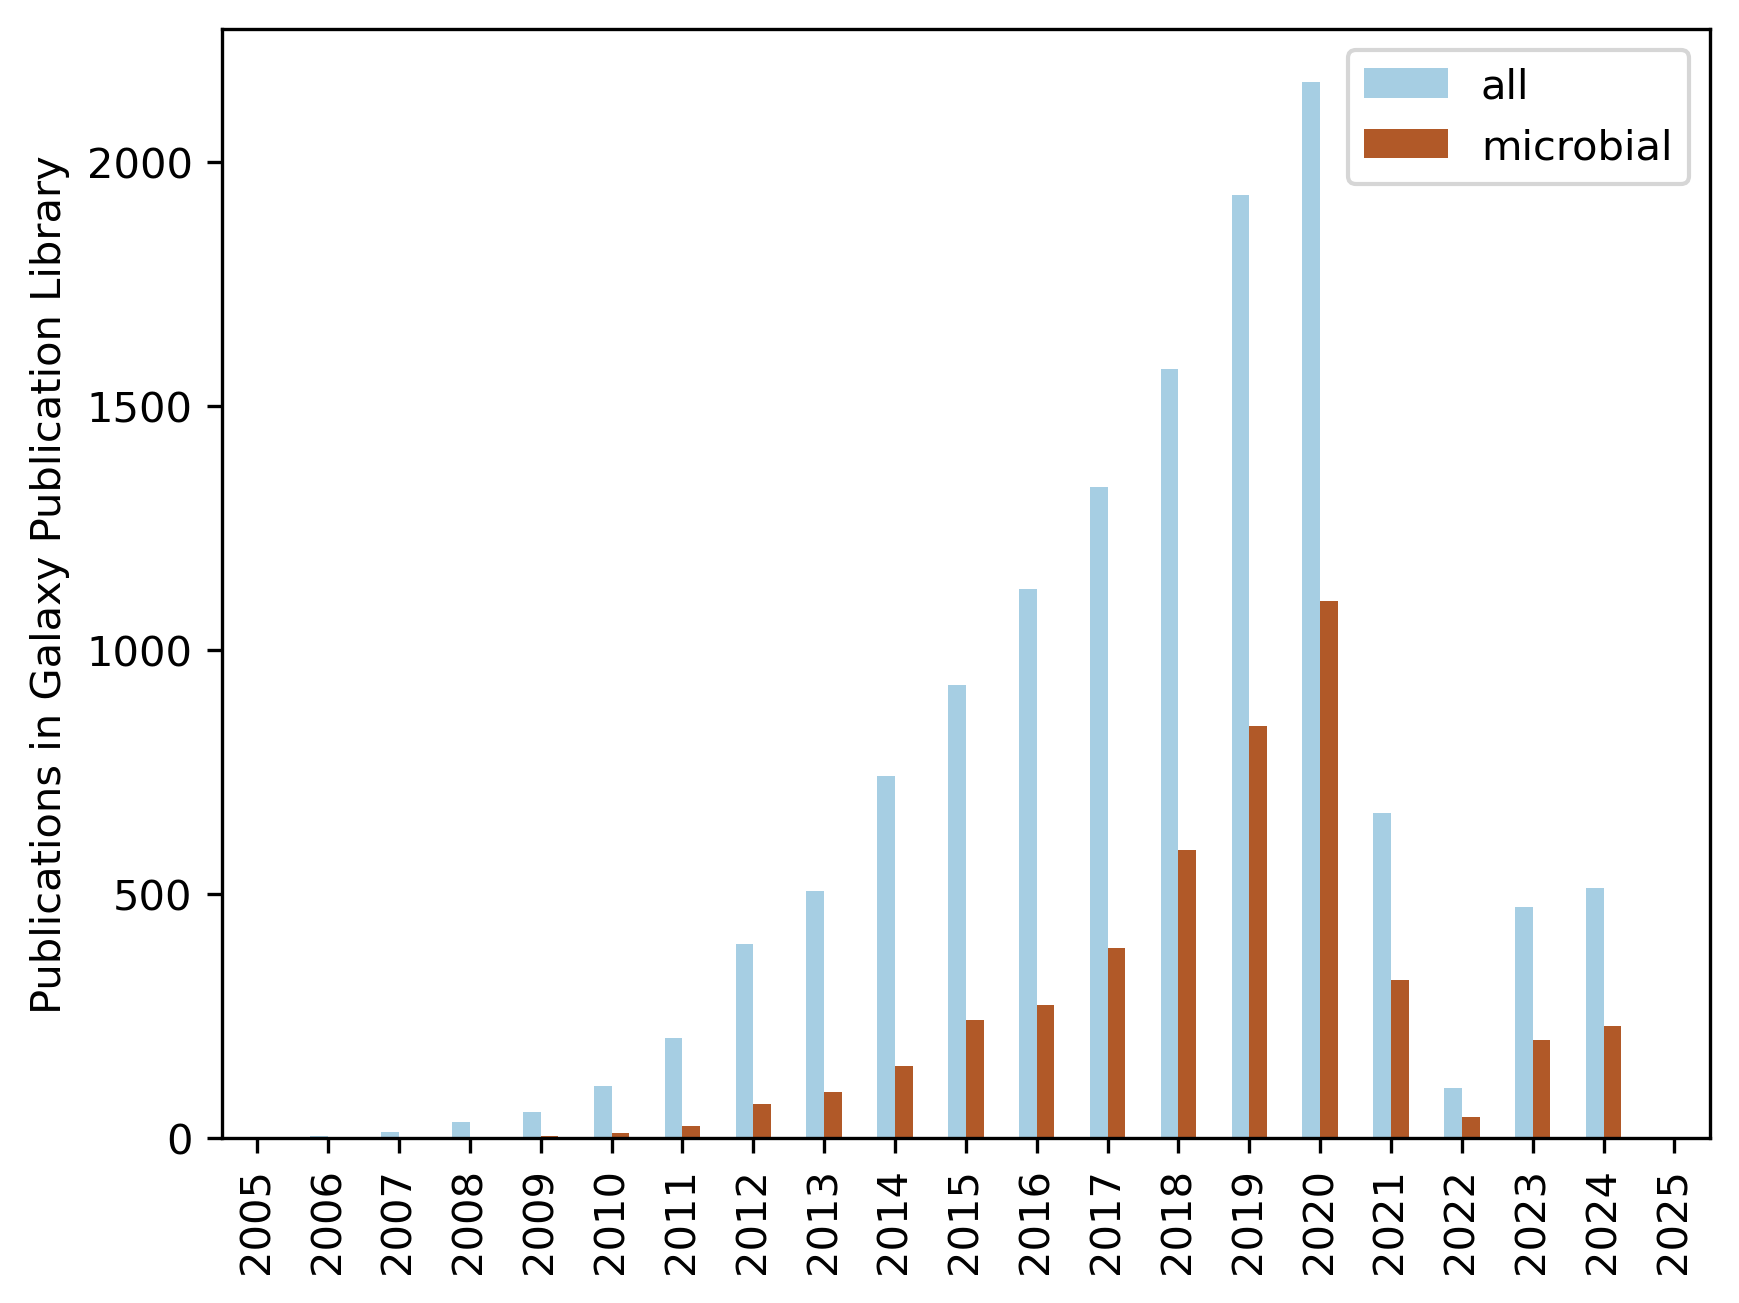

In [26]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(year_df
     .plot.bar(ax=ax, colormap='Paired'))
plt.ylabel('Publications in Galaxy Publication Library')

### Per keywords

We group the extracted publications by pre-defined groups given keywords in tags, title, and/or abstract.

In [12]:
not_grouped = []
grouping_keywords = create_grouping_keywords()
for item in conserved_items:
    in_group = False
    for g, group in grouping_keywords.items():
        for sg, subgroup in group.items():
            found = False
            if 'tag' in subgroup['location']:
                for tag in item['data']['tags']:
                    found |= find_kw(tag['tag'].lower(), subgroup['keywords'])
            if 'title' in subgroup['location'] and 'title' in item['data']:
                found |= find_kw(item['data']['title'].lower(), subgroup['keywords'])
            if 'abstract' in subgroup['location'] and 'abstractNote' in item['data']:
                found |= find_kw(item['data']['abstractNote'].lower(), subgroup['keywords'])
            subgroup['counts'] += found
            in_group |= found

    if not in_group:
        not_grouped.append(item)

Number of elements not grouped

In [13]:
f'{len(not_grouped)} / {len(conserved_items)}'

'21 / 4594'

In [14]:
group_dfs = {}
for g, group in grouping_keywords.items():
    group_dfs[g] = (pd.DataFrame.from_dict(group, orient='index')
                    .assign(percentage=lambda df: 100*df.counts/len(conserved_items)))

Text(0, 0.5, '% in the microbial related publications from Galaxy Publication Library')

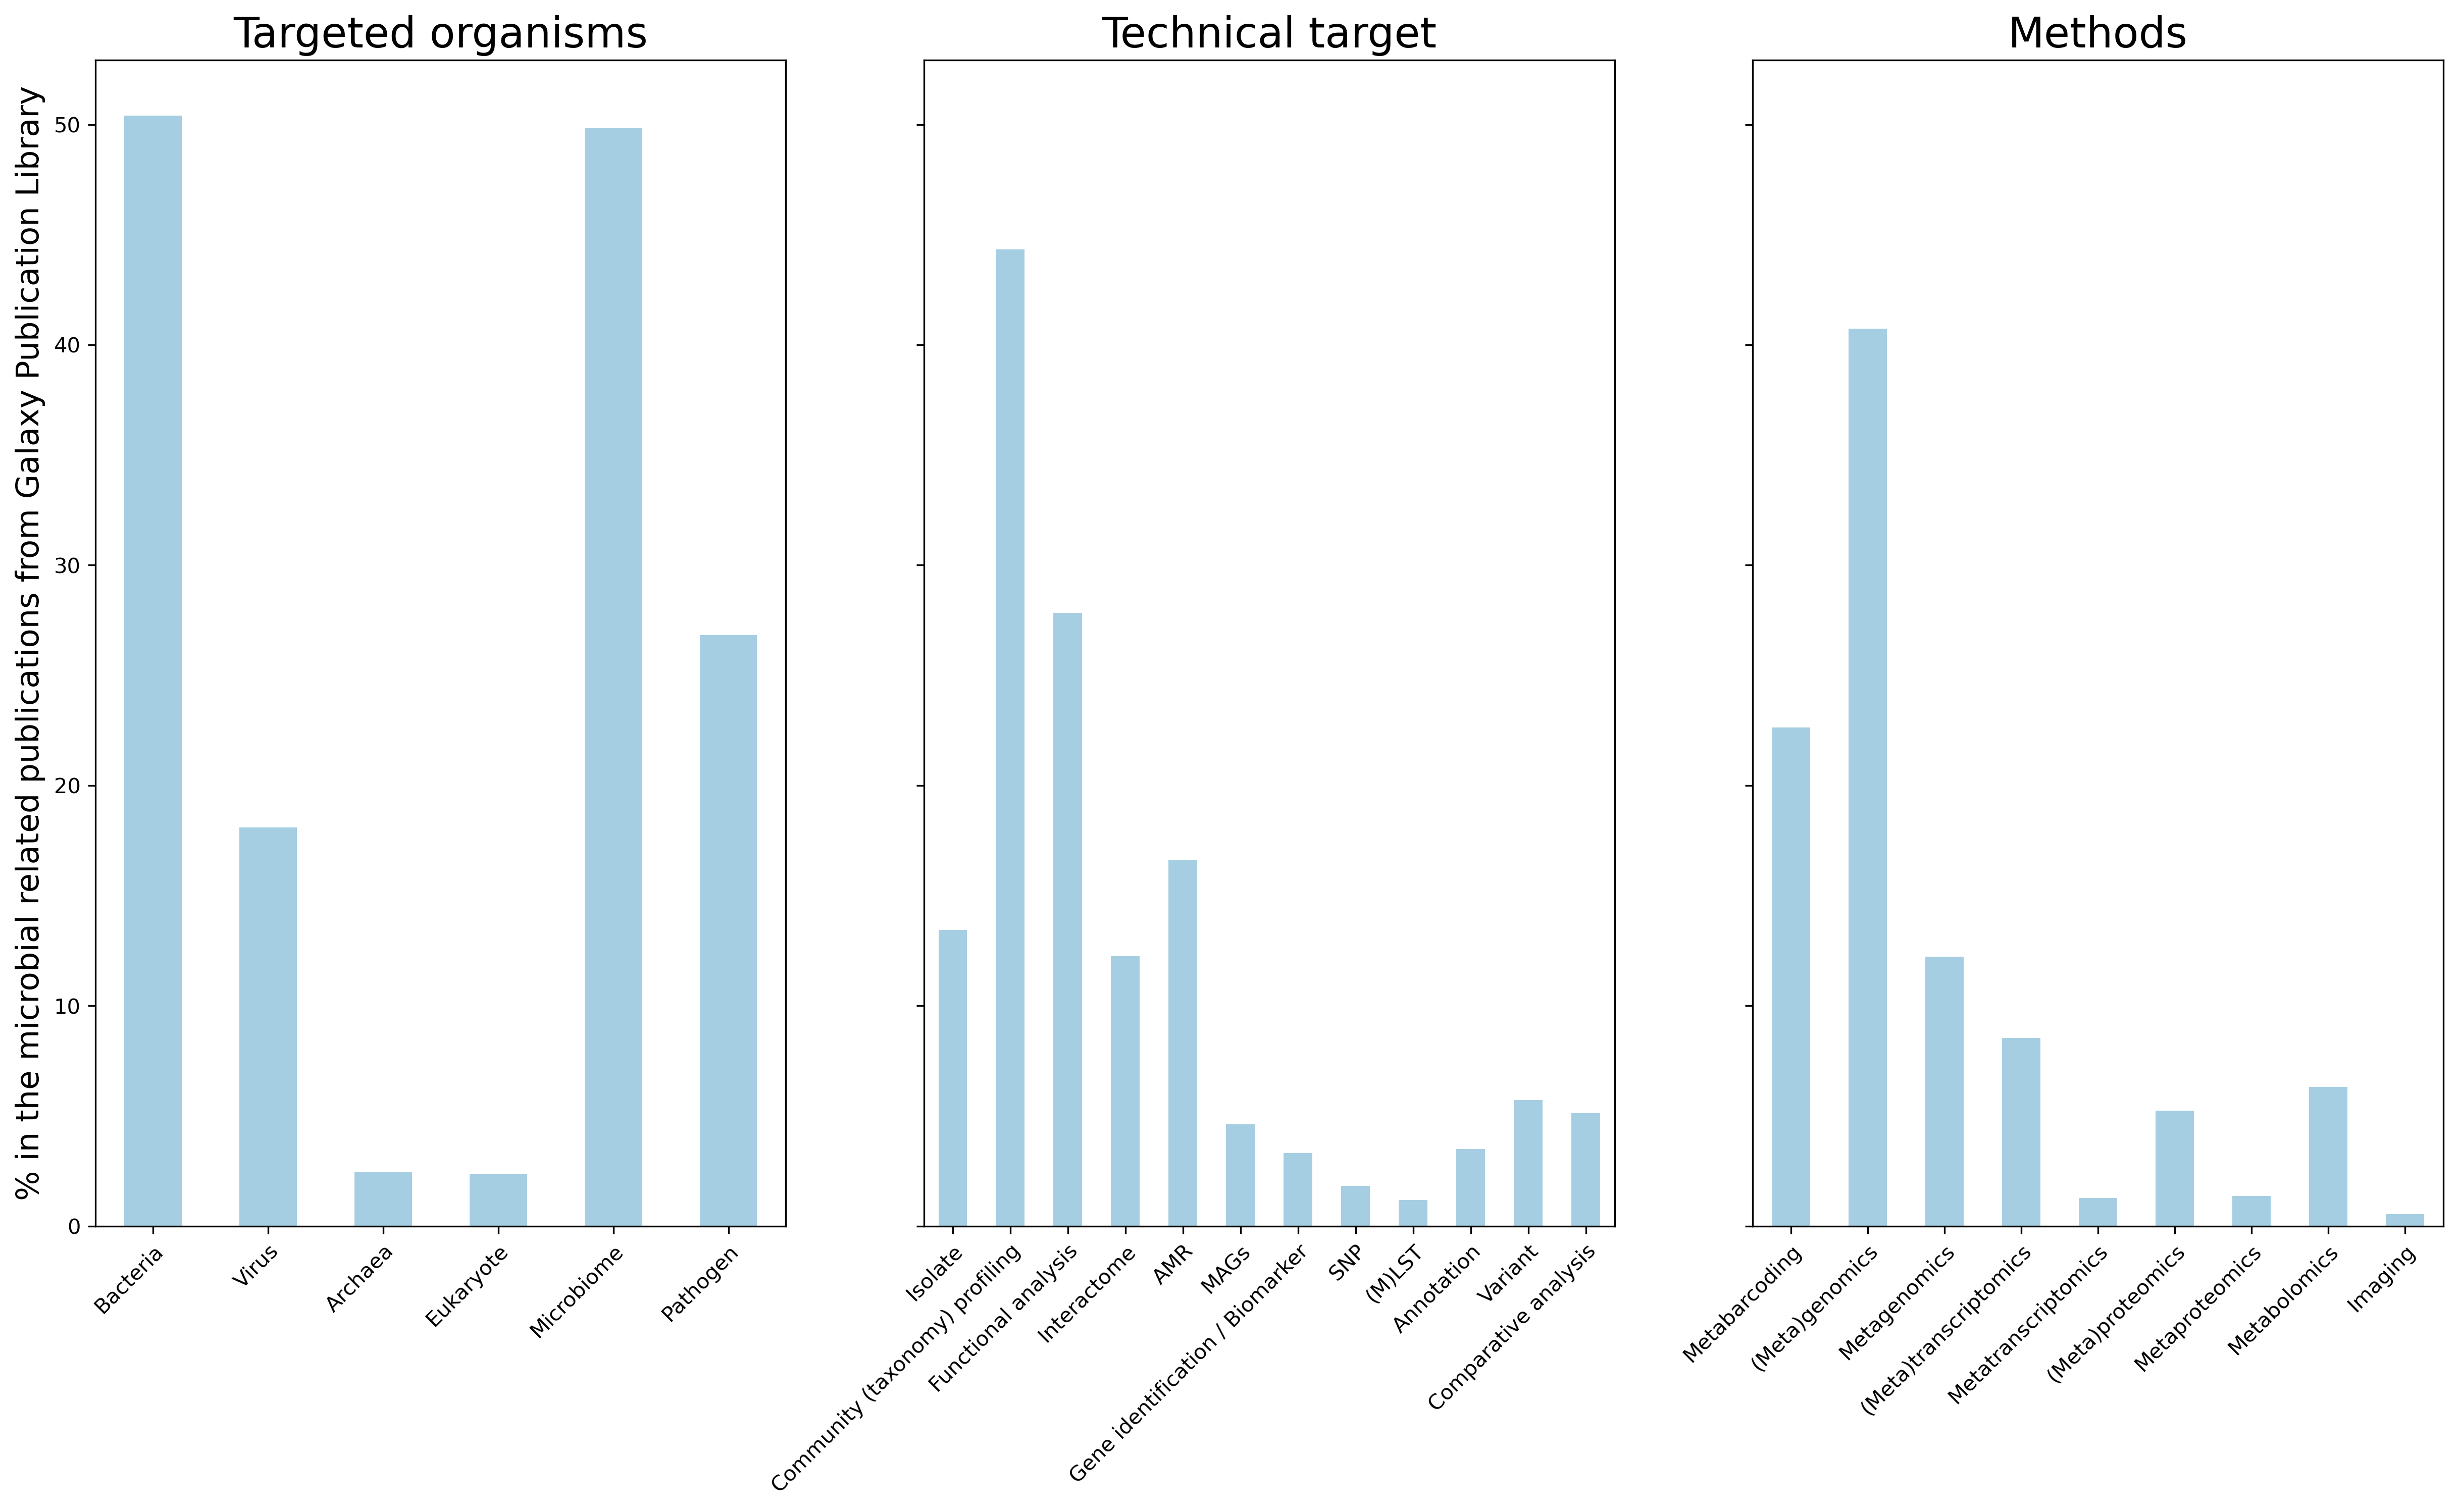

In [15]:
def plot_kw_percentage(group, dfs, ax):
    '''
    Plot percentage of publications with keywords related a group

    :param group: group
    :param dfs: dictionary with dataframes
    :param ax: axis
    '''    
    (dfs[group].percentage
         .plot.bar(ax=ax, colormap='Paired'))
    #plt.xticks(rotation=45, ha='right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(group, fontsize=20)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 10))
fig.set_dpi(300)
for i, group in enumerate(group_dfs):
    plot_kw_percentage(group, group_dfs, axs[i])
axs[0].set_ylabel('% in the microbial related publications from Galaxy Publication Library', fontsize=15)

# Google Scholar and Semantic Search

There is now a [Google Scholar profile](https://scholar.google.de/citations?hl=de&user=3tSiRGoAAAAJ) with all major publications of the Galaxy Project. We can use it to extract the citations for the papers using Semantic Search (Google Scholar blocking requests on citations)

In [78]:
def start_proxy():
    success = pg.FreeProxies()#SingleProxy(http = proxy, https = proxy)
    scholarly.use_proxy(pg)
    
def get_request_json(url: str, headers: dict, retries: int = 3, delay: float = 120) -> dict:
    """
    Perform a GET request to retrieve JSON output from a specified URL, with retry on ConnectionError.

    :param url: URL to send the GET request to.
    :param headers: Headers to include in the GET request.
    :param retries: Number of retry attempts in case of a ConnectionError (default is 3).
    :param delay: Delay in seconds between retries (default is 2.0 seconds).
    :return: JSON response as a dictionary, or None if all retries fail.
    :raises ConnectionError: If all retry attempts fail due to a connection error.
    :raises SystemExit: For any other request-related errors.
    """
    attempt = 0  # Track the number of attempts

    while attempt < retries:
        try:
            r = requests.get(url, auth=None, headers=headers)
            r.raise_for_status()  # Raises an HTTPError for unsuccessful status codes
            return r.json()  # Return JSON response if successful
        except requests.exceptions.HTTPError as e:
            attempt += 1
            if attempt == retries:
                raise ConnectionError(
                    "Connection aborted after multiple retries: Remote end closed connection without response"
                ) from e
            print(f"Connection error on attempt {attempt}/{retries}. Retrying in {delay} seconds...")
            time.sleep(delay)  # Wait before retrying
        except requests.exceptions.RequestException as e:
            # Handles all other exceptions from the requests library
            raise SystemExit(f"Request failed: {e}")
        except ValueError as e:
            # Handles cases where the response isn't valid JSON
            raise ValueError("Response content is not valid JSON") from e

    # Return None if all retries are exhausted and no response is received
    return {}

def find_paper_id(title):
    "From semanticscholar"
    url = f"https://api.semanticscholar.org/graph/v1/paper/search/match?query={title}"
    response = get_request_json(url, {"Accept": "application/json"})
    if "data" in response:
        return response["data"][0]["paperId"]
    else:
        raise ValueError(f"{title} not found")
        
def get_citation_number(paper_id):
    "From semanticscholar"
    url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=citationCount"
    response = get_request_json(url, {"Accept": "application/json"})
    if "citationCount" in response:
        return response["citationCount"]
    else:
        raise ValueError(f"No citation count found for {paper_id}")
        
def get_citations(paper_id, offset, limit):
    "From semanticscholar"
    url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}/citations?fields=title,abstract,year&offset={offset}&limit={limit}"
    response = get_request_json(url, {"Accept": "application/json"})
    if "data" in response:
        return response["data"]
    else:
        raise ValueError(f"No citation found for {paper_id} with offset={offset} and limit={limit}")

In [39]:
pg = ProxyGenerator()
start_proxy()
search_query = scholarly.search_author("Galaxy Project")
author = scholarly.fill(next(search_query))

In [103]:
citations = []
for pub in author["publications"]:
    # Keep only majors Galaxy papers
    keep = False
    for k in ["platform", "a comprehensive approach", "a web‐based genome analysis tool for experimentalists"]:
        if k in pub["bib"]["title"]:
            keep = True
    if not keep:
        continue
        
    print(pub["bib"]["title"])
    print(pub["bib"]["pub_year"])
        
    # Search citations using SemanticScholar
    paper_id = find_paper_id(pub["bib"]["title"])
    citation_number = get_citation_number(paper_id)
    print(f"Citations: {citation_number}")
    
    limit = 1000
    for n in range(0, citation_number, limit):
        citations.extend(get_citations(paper_id, n, limit))
        time.sleep(30)
    time.sleep(60)
    print()

Galaxy: a comprehensive approach for supporting accessible, reproducible, and transparent computational research in the life sciences
2010
Citations: 3583
The Galaxy platform for accessible, reproducible and collaborative biomedical analyses: 2018 update
2018
Citations: 953
Galaxy: a platform for interactive large-scale genome analysis
2005
Citations: 2100
The Galaxy platform for accessible, reproducible and collaborative biomedical analyses: 2016 update
2016
Citations: 3568
Galaxy: a web‐based genome analysis tool for experimentalists
2010
Citations: 1547
Ten simple rules for reproducible computational research
2013
Manipulation of FASTQ data with Galaxy
2010
The Galaxy platform for accessible, reproducible and collaborative biomedical analyses: 2020 update
2020
Citations: 579
The Galaxy platform for accessible, reproducible and collaborative biomedical analyses: 2022 update
2022
Citations: 300
Next-generation sequencing data interpretation: enhancing reproducibility and accessibility

In [104]:
years = {
    "all": {},
    "microbial": {}
}
max_year = datetime.date.today().year+2
for y in range(2005, max_year):
    years["all"].setdefault(f"{y}", 0)
    years["microbial"].setdefault(f"{y}", 0)
    
grouping_keywords = create_grouping_keywords()

for citation in citations:
    # get year
    year = citation["citingPaper"]["year"]
    if year is None or year < int(pub["bib"]["pub_year"]):
        continue
    year = str(year)
    if year not in years["all"]:
        continue
    years["all"][year] += 1

    # check if microbio
    microbio = False
    for t in searched_tags:
        if t in citation["citingPaper"]["title"]:
            microbio = True
        if citation["citingPaper"]["abstract"] is not None and t in citation["citingPaper"]["abstract"]:
            microbio = True

    if microbio:
        # count keywords
        years["microbial"][year] += 1
        for g, group in grouping_keywords.items():
            for sg, subgroup in group.items():
                found = False
                if "title" in subgroup["location"]:
                    found |= find_kw(citation["citingPaper"]["title"].lower(), subgroup["keywords"])
                if "abstract" in subgroup["location"] and citation["citingPaper"]["abstract"] is not None:
                    found |= find_kw(citation["citingPaper"]["abstract"].lower(), subgroup["keywords"])
                subgroup["counts"] += found
        

Text(0, 0.5, 'Publications citing Galaxy Papers')

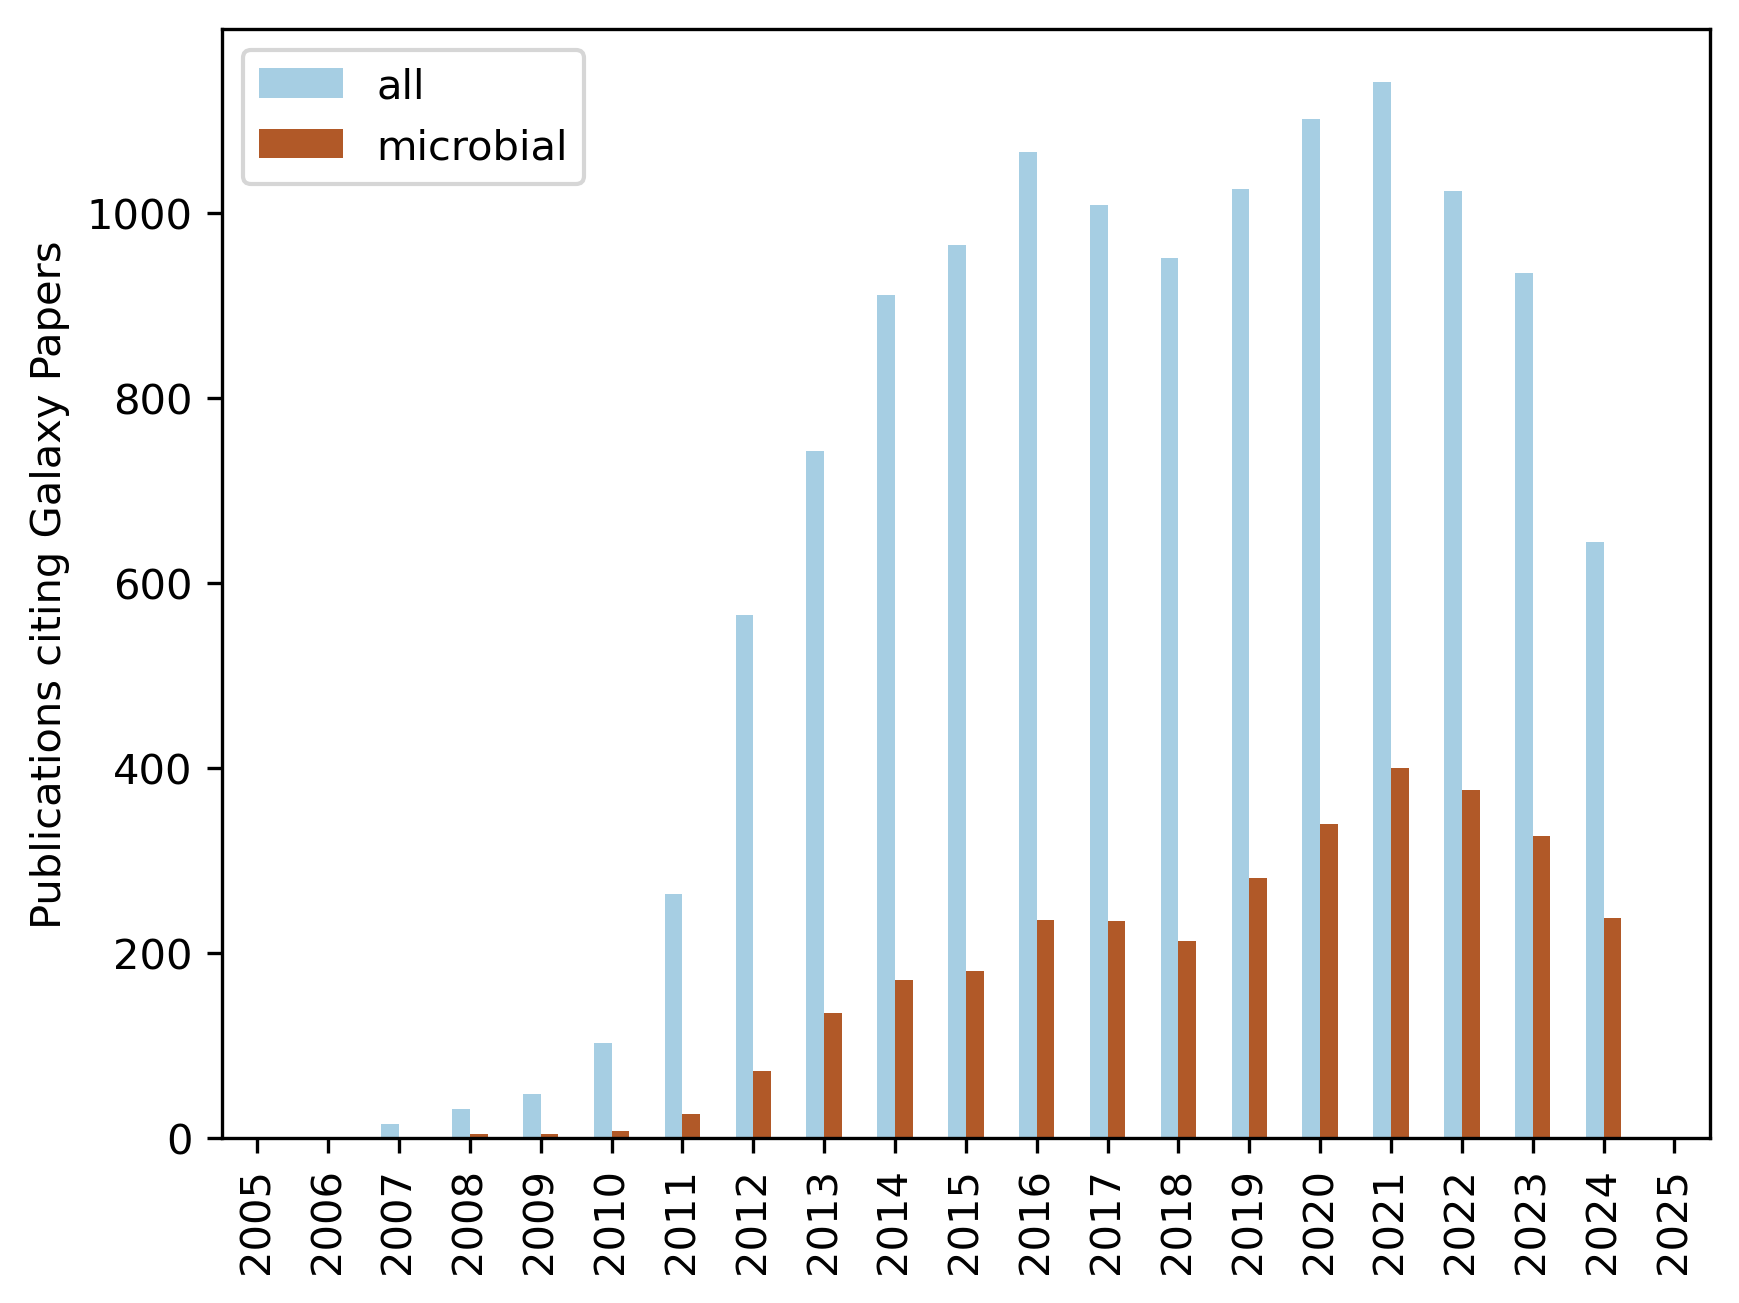

In [105]:
year_df = pd.DataFrame.from_dict(years)
fig, ax = plt.subplots()
fig.set_dpi(300)
(year_df
     .plot.bar(ax=ax, colormap='Paired'))
plt.ylabel('Publications citing Galaxy Papers')

Number of publication citing Galaxy

In [109]:
sum(years["all"].values())

12545

Percentage of Microbial-related publications citing Galaxy

In [111]:
100*sum(years["microbial"].values())/sum(years["all"].values())

25.85890793144679

In [106]:
group_dfs = {}
conserved_items = sum(years["all"].values())
for g, group in grouping_keywords.items():
    group_dfs[g] = (pd.DataFrame.from_dict(group, orient='index')
                    .assign(percentage=lambda df: 100*df.counts/conserved_items))

Text(0, 0.5, '% in the microbial related papers citing Galaxy Papers')

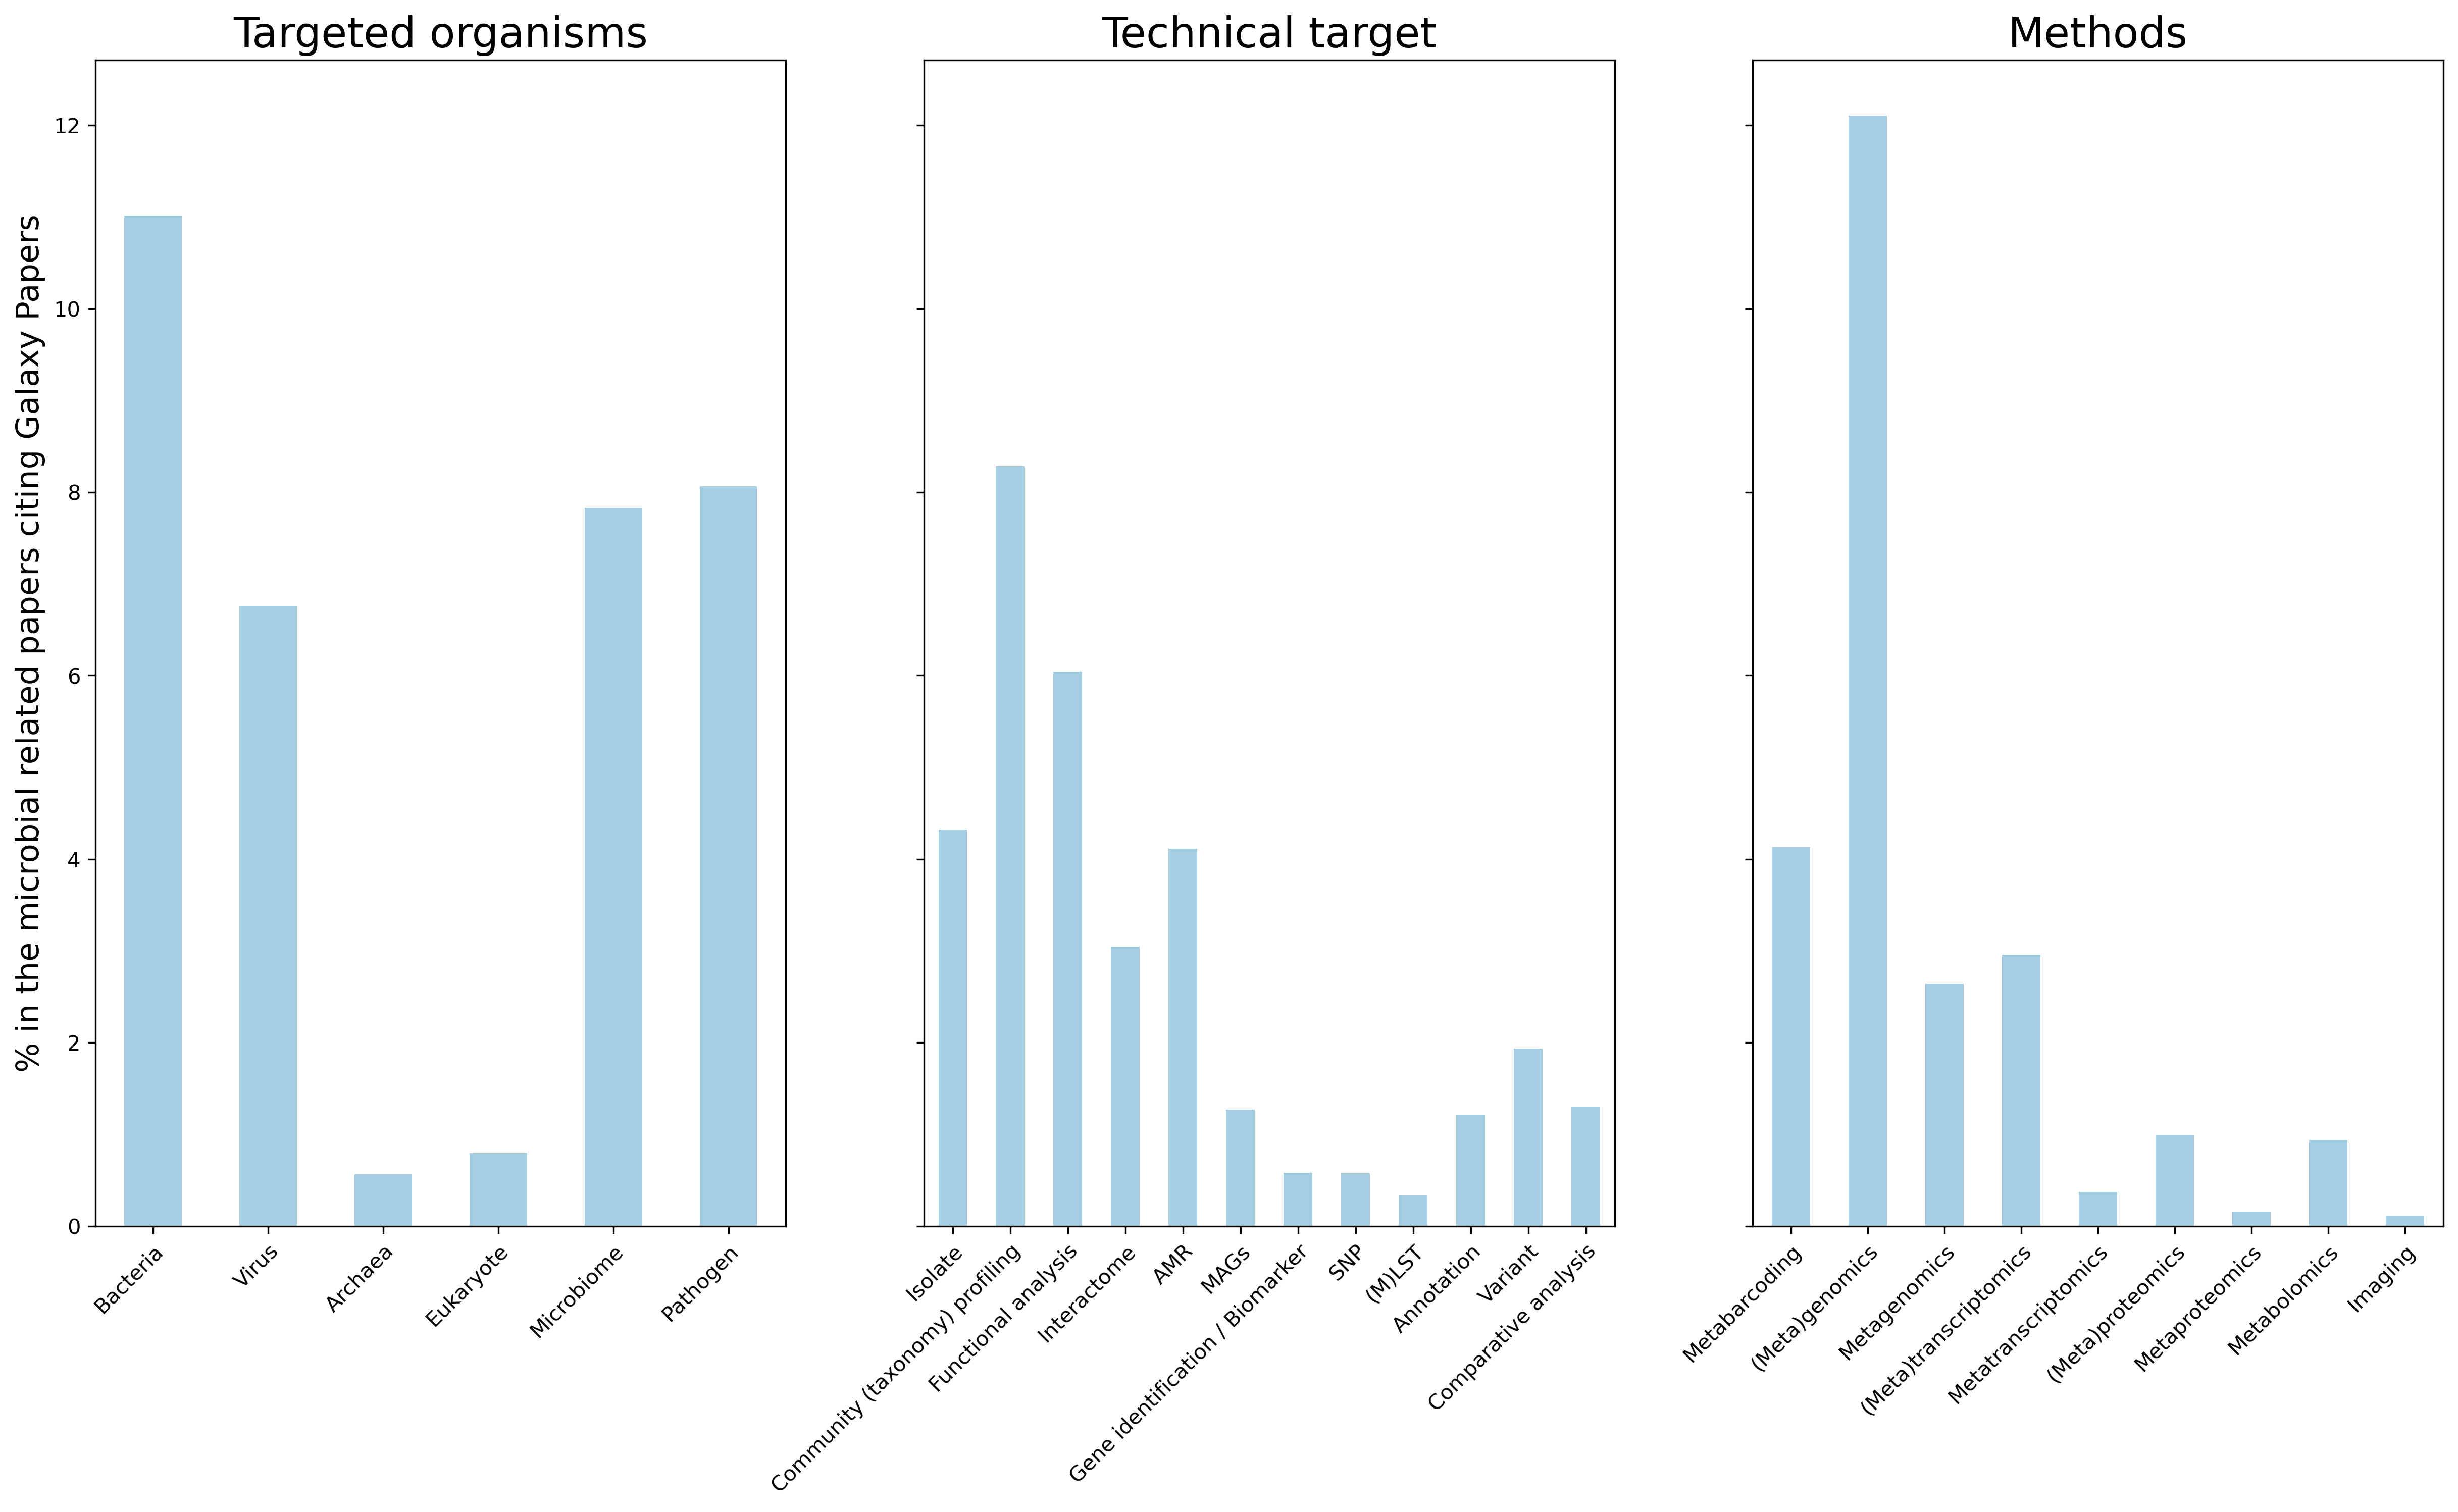

In [107]:
def plot_kw_percentage(group, dfs, ax):
    '''
    Plot percentage of publications with keywords related a group

    :param group: group
    :param dfs: dictionary with dataframes
    :param ax: axis
    '''    
    (dfs[group].percentage
         .plot.bar(ax=ax, colormap='Paired'))
    #plt.xticks(rotation=45, ha='right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(group, fontsize=20)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 10))
fig.set_dpi(300)
for i, group in enumerate(group_dfs):
    plot_kw_percentage(group, group_dfs, axs[i])
axs[0].set_ylabel('% in the microbial related papers citing Galaxy Papers', fontsize=15)